In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import torch
import csv
import pandas as pd
import seaborn as sns
from os import listdir
from os.path import isfile, join, exists
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
import shap
from sklearn.metrics import accuracy_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from pathlib import Path

from edm.utils.embeddings import get_cohort_df, clean_additional_columns
from edm.utils.measures import perf_measure, calculate_output_statistics, calculate_confidence_intervals, get_bootstrap_metrics

from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve


pd.set_option('display.max_columns', None)

## Age + Sex + Vital Signs

In [2]:
df_train = pd.read_csv("/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.train.txt", sep="\t", na_values='?')
df_val = pd.read_csv("/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.val.txt", sep="\t", na_values='?')
df_test = pd.read_csv("/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.test.txt", sep="\t", na_values='?')


In [3]:
additional_cols = ["Age", "Gender", "SpO2", "RR", "HR", "Temp", "SBP", "DBP"]
ordinal_cols = ["Gender"]

In [4]:
df_train = get_cohort_df(df_train, additional_cols=additional_cols)
df_val = get_cohort_df(df_val, additional_cols=additional_cols)
df_test = get_cohort_df(df_test, additional_cols=additional_cols)

In [5]:
df_train, df_val, df_test = clean_additional_columns(df_train, df_val, df_test, 
                                                     cols_to_clean=additional_cols, ordinal_cols=ordinal_cols, impute=True, normalize=True)

In [ ]:
df_train.head(3)

In [7]:
df_train_y = df_train["outcome"]
df_train_x = df_train.drop(["patient_id", "outcome"], axis=1)

df_val_y = df_val["outcome"]
df_val_x = df_val.drop(["patient_id", "outcome"], axis=1)

df_test_y = df_test["outcome"]
df_test_x = df_test.drop(["patient_id", "outcome"], axis=1)

Starting model training...


=== TRAIN ===


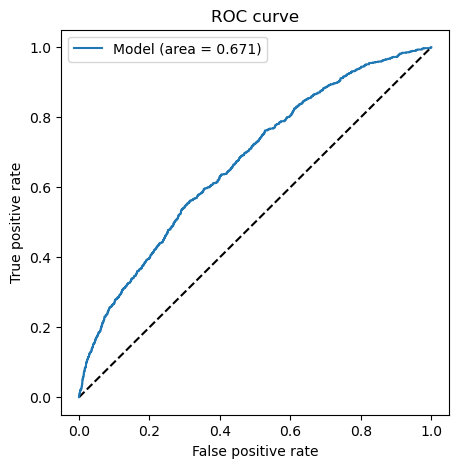

[DeLong] AUC=0.671, AUC COV=0.0, 95% CI=[0.651, 0.691]; AUPRC=0.183, 95% CI=N/A
TRAIN AUROC = (0.6711165739169062, 0.18319496723150833) AUPRC = 0.18319496723150833 using data size 8162 with 757 pos


=== VAL ===


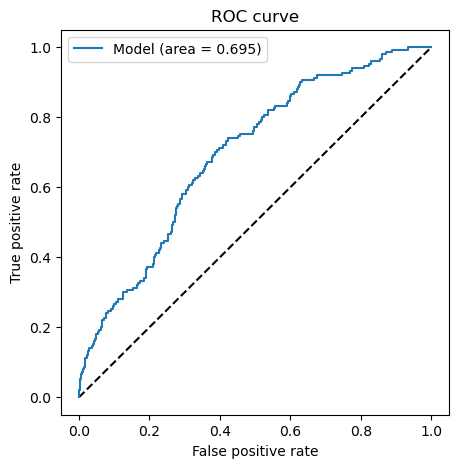

[DeLong] AUC=0.695, AUC COV=0.0, 95% CI=[0.653, 0.737]; AUPRC=0.243, 95% CI=N/A
VAL AUROC = (0.6949751243781095, 0.2430127668376574) AUPRC = 0.2430127668376574 using data size 1356 with 150 pos


=== TEST ===


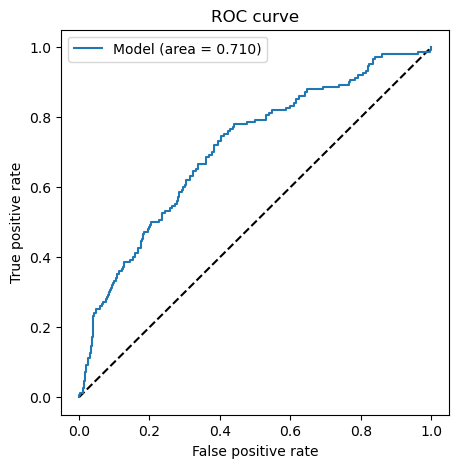

  0%|          | 4/10000 [00:00<05:05, 32.73it/s]

[DeLong] AUC=0.71, AUC COV=0.001, 95% CI=[0.665, 0.755]; AUPRC=0.236, 95% CI=N/A


100%|██████████| 10000/10000 [05:08<00:00, 32.45it/s]

[Bootstrap] AUC=0.71, 95% CI=[0.664, 0.753]; AUPRC=0.236, 95% CI=[0.187, 0.299]
TEST AUROC = (0.7098507462686566, 0.2361895732891205) AUPRC = 0.2361895732891205 using data size 1356 with 150 pos


In [9]:
print(f"Starting model training...")
clf = LogisticRegression(random_state=42, class_weight="balanced", max_iter=1000)
clf.fit(df_train_x, df_train_y)

print()
print()
print(f"=== TRAIN ===")
y_train_pred = clf.predict_proba(df_train_x)[:, 1]
auroc_train = calculate_output_statistics(df_train_y.tolist(), y_train_pred)
calculate_confidence_intervals(df_train_y.tolist(), y_train_pred, ci_type="delong")
precision, recall, _ = precision_recall_curve(df_train_y.tolist(), y_train_pred)
auprc_alt = auc(recall, precision)
print(f"TRAIN AUROC = {auroc_train} AUPRC = {auprc_alt} using data size {len(y_train_pred)} with {sum(df_train_y.tolist())} pos")

print()
print()
print(f"=== VAL ===")
y_val_pred = clf.predict_proba(df_val_x)[:, 1]
auroc_val = calculate_output_statistics(df_val_y.tolist(), y_val_pred)
calculate_confidence_intervals(df_val_y.tolist(), y_val_pred, ci_type="delong")
precision, recall, _ = precision_recall_curve(df_val_y.tolist(), y_val_pred)
auprc_alt = auc(recall, precision)
print(f"VAL AUROC = {auroc_val} AUPRC = {auprc_alt} using data size {len(y_val_pred)} with {sum(df_val_y.tolist())} pos")

print()
print()
print(f"=== TEST ===")
y_test_pred = clf.predict_proba(df_test_x)[:, 1]
auroc_test = calculate_output_statistics(df_test_y.tolist(), y_test_pred)
calculate_confidence_intervals(df_test_y.tolist(), y_test_pred, ci_type="delong")
calculate_confidence_intervals(df_test_y.tolist(), y_test_pred, ci_type="bootstrap")
precision, recall, _ = precision_recall_curve(df_test_y.tolist(), y_test_pred)
auprc_alt = auc(recall, precision)
print(f"TEST AUROC = {auroc_test} AUPRC = {auprc_alt} using data size {len(y_test_pred)} with {sum(df_test_y.tolist())} pos")


## Age + Sex + Vital Signs + Risk

In [3]:
df_train = pd.read_csv("/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.train.txt", sep="\t", na_values='?')
df_val = pd.read_csv("/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.val.txt", sep="\t", na_values='?')
df_test = pd.read_csv("/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.test.txt", sep="\t", na_values='?')


In [4]:
additional_cols = ["Age", "Gender", "SpO2", "RR", "HR", "Temp", "SBP", "DBP", "Athero", "HTN", "HLD", "DM", "Obese", "Smoking"]
ordinal_cols = ["Gender"]

In [5]:
df_train = get_cohort_df(df_train, additional_cols=additional_cols)
df_val = get_cohort_df(df_val, additional_cols=additional_cols)
df_test = get_cohort_df(df_test, additional_cols=additional_cols)

In [6]:
df_train, df_val, df_test = clean_additional_columns(df_train, df_val, df_test, 
                                                     cols_to_clean=additional_cols, ordinal_cols=ordinal_cols, impute=True, normalize=True)

In [ ]:
df_train.head(3)

In [8]:
df_train_pt = df_train["patient_id"]
df_train_y = df_train["outcome"]
df_train_x = df_train.drop(["patient_id", "outcome"], axis=1)

df_val_pt = df_val["patient_id"]
df_val_y = df_val["outcome"]
df_val_x = df_val.drop(["patient_id", "outcome"], axis=1)

df_test_pt = df_test["patient_id"]
df_test_y = df_test["outcome"]
df_test_x = df_test.drop(["patient_id", "outcome"], axis=1)

Starting model training...


=== TRAIN ===


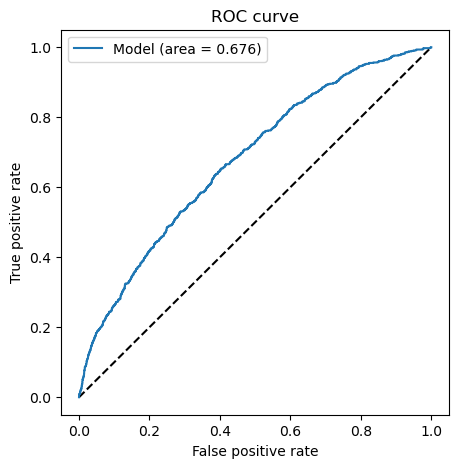

[DeLong] AUC=0.676, AUC COV=0.0, 95% CI=[0.656, 0.695]; AUPRC=0.188, 95% CI=N/A
TRAIN AUROC = (0.6757426744933848, 0.18848998032827852) AUPRC = 0.18848998032827852 using data size 8162 with 757 pos


=== VAL ===


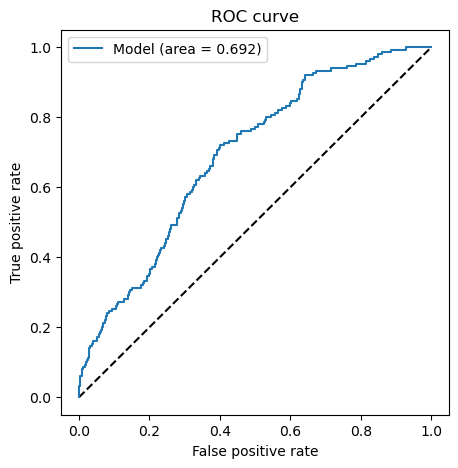

[DeLong] AUC=0.692, AUC COV=0.0, 95% CI=[0.651, 0.733]; AUPRC=0.242, 95% CI=N/A
VAL AUROC = (0.7098507462686566, 0.2361895732891205) AUPRC = 0.2418020162909566 using data size 1356 with 150 pos


=== TEST ===


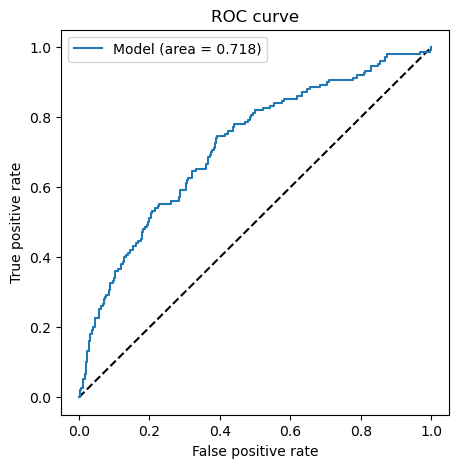

  0%|          | 4/10000 [00:00<05:07, 32.53it/s]

[DeLong] AUC=0.718, AUC COV=0.001, 95% CI=[0.673, 0.762]; AUPRC=0.247, 95% CI=N/A


100%|██████████| 10000/10000 [05:07<00:00, 32.47it/s]

[Bootstrap] AUC=0.718, 95% CI=[0.673, 0.761]; AUPRC=0.247, 95% CI=[0.196, 0.315]
TEST AUROC = (0.7175511332227751, 0.24681066643511815) AUPRC = 0.24681066643511815 using data size 1356 with 150 pos


In [16]:
print(f"Starting model training...")
clf = LogisticRegression(random_state=42, class_weight="balanced", max_iter=1000)
clf.fit(df_train_x, df_train_y)

print()
print()
print(f"=== TRAIN ===")
y_train_pred = clf.predict_proba(df_train_x)[:, 1]
auroc_train = calculate_output_statistics(df_train_y.tolist(), y_train_pred)
calculate_confidence_intervals(df_train_y.tolist(), y_train_pred, ci_type="delong")
precision, recall, _ = precision_recall_curve(df_train_y.tolist(), y_train_pred)
auprc_alt = auc(recall, precision)
print(f"TRAIN AUROC = {auroc_train} AUPRC = {auprc_alt} using data size {len(y_train_pred)} with {sum(df_train_y.tolist())} pos")


Path(f"/deep/group/ed-monitor/patient_data_v9/predictions/baseline").mkdir(parents=True, exist_ok=True)
with open(f"/deep/group/ed-monitor/patient_data_v9/predictions/baseline/train.csv", "w") as fp:
    writer = csv.writer(fp, delimiter=",")
    writer.writerow(["patient_id", "preds", "actual"])
    for ind in range(len(df_train_pt)):
        writer.writerow([df_train_pt[ind], y_train_pred[ind], df_train_y.tolist()[ind]])

print()
print()
print(f"=== VAL ===")
y_val_pred = clf.predict_proba(df_val_x)[:, 1]
auroc_val = calculate_output_statistics(df_val_y.tolist(), y_val_pred)
calculate_confidence_intervals(df_val_y.tolist(), y_val_pred, ci_type="delong")

precision, recall, _ = precision_recall_curve(df_val_y.tolist(), y_val_pred)
auprc_alt = auc(recall, precision)
print(f"VAL AUROC = {auroc_test} AUPRC = {auprc_alt} using data size {len(y_val_pred)} with {sum(df_val_y.tolist())} pos")

with open(f"/deep/group/ed-monitor/patient_data_v9/predictions/baseline/val.csv", "w") as fp:
    writer = csv.writer(fp, delimiter=",")
    writer.writerow(["patient_id", "preds", "actual"])
    for ind in range(len(df_val_pt)):
        writer.writerow([df_val_pt[ind], y_val_pred[ind], df_val_y.tolist()[ind]])

print()
print()
print(f"=== TEST ===")
y_test_pred = clf.predict_proba(df_test_x)[:, 1]
auroc_test = calculate_output_statistics(df_test_y.tolist(), y_test_pred)
calculate_confidence_intervals(df_test_y.tolist(), y_test_pred, ci_type="delong")
calculate_confidence_intervals(df_test_y.tolist(), y_test_pred, ci_type="bootstrap")
precision, recall, _ = precision_recall_curve(df_test_y.tolist(), y_test_pred)
auprc_alt = auc(recall, precision)
print(f"TEST AUROC = {auroc_test} AUPRC = {auprc_alt} using data size {len(y_test_pred)} with {sum(df_test_y.tolist())} pos")

with open(f"/deep/group/ed-monitor/patient_data_v9/predictions/baseline/test.csv", "w") as fp:
    writer = csv.writer(fp, delimiter=",")
    writer.writerow(["patient_id", "preds", "actual"])
    for ind in range(len(df_test_pt)):
        writer.writerow([df_test_pt[ind], y_test_pred[ind], df_test_y.tolist()[ind]])

In [2]:
# Get bootstrap again, but this time with a fixed seed
# 

def get_ci(bootstrap_aucs, bootstrap_auprcs, y_actual, y_pred, alpha=0.95):
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(bootstrap_aucs, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(bootstrap_aucs, p))

    auc_ci = [round(lower, 3), round(upper, 3)]

    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_actual, y_pred)
    auc_keras = auc(fpr_keras, tpr_keras)

    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(bootstrap_auprcs, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(bootstrap_auprcs, p))

    auprc_ci = [round(lower, 3), round(upper, 3)]

    precision, recall, _ = precision_recall_curve(y_actual, y_pred)
    auprc = auc(recall, precision)

    print(f"[Bootstrap] AUC={round(auc_keras, 3)}, 95% CI={auc_ci}; AUPRC={round(auprc, 3)}, 95% CI={auprc_ci}")

df_waveform = pd.read_csv(f"/deep/group/ed-monitor/patient_data_v9/predictions/baseline/test.csv")
waveforms_aucs, waveforms_auprcs = get_bootstrap_metrics(df_waveform["preds"].tolist(), df_waveform["actual"].tolist())
get_ci(waveforms_aucs, waveforms_auprcs, df_waveform["actual"].tolist(), df_waveform["preds"].tolist())

100%|██████████| 10000/10000 [04:52<00:00, 34.22it/s]

[Bootstrap] AUC=0.718, 95% CI=[0.673, 0.761]; AUPRC=0.247, 95% CI=[0.196, 0.313]
